### CS4287, Assignment 1: CNN
Bayan Nezamabad - 20251971, Euan Bourke - 21332142

The code executes to the end without errors

While we did not reuse any existing implementations, a list of articles/documentation that was used to gain a better understanding of AlexNet and libraries we used is provided at the end of this notebook 

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from keras import utils, Sequential, layers
import time
from sklearn import metrics
import os
from keras import backend

In [2]:
# Hyper Params
EPOCHS = 30
BATCH_SIZE = 128
OPTIMIZER = 'adam' # Default learning rate is 0.001

VERBOSE = 1
LOSS = "categorical_crossentropy"
METRICS = ["accuracy", "precision", "recall"]

IMG_ROW, IMG_COL = 227, 227 # Image dimensions
INPUT_SHAPE = (IMG_ROW, IMG_COL, 3) # 3 as RGB
NB_CLASSES = 100 # 100 different classifications for 100 different species of butterfly or moth

TRAIN_PATH = "data/train"
VALID_PATH = "data/valid"
TEST_PATH = "data/test"
SEED = 123 # used for consistent randomisation of the dataset

# The Data Set
We chose a dataset consisting of images of butterflies and moths of 100 unique species (hence 100 unique classes).
The dataset provided images for training, validation, and testing which is why we are loading a set of validation images instead of splitting the training set into training data and validation data (later in cross fold validation we do split the training dataset into training data and validation data).

From the dataset there are many potential features one could identify but it's hard to tell what features our model will extract so to visualise the dataset, we will present a random sample image for 9 random classes. Some potential features that may contribute to successful classification are wing patterns, colours, wing shapes, body shapes, etc.
We will also visualise the number of images per class in the form of a bar chart so that we may refer to it when evaluating our results, perhaps in case of any underfitting or overfitting. There isn't a huge amount of variance between the classes with an average training set size of 125 images but there are still a few outliers.

Since we are using AlexNet, some preprocessing is performed upon loading our data. AlexNet requires that inputs have a shape of 227x227x3 but the images in our dataset are of size 224x224x3 so we resize the images in the code cell below.

In [3]:
# Loading and preparing training, validation, and testing data
# Images are originally 224x224 so we have to resize them to 227x227, the input size of AlexNet
train_data = utils.image_dataset_from_directory(TRAIN_PATH,
                                                shuffle=True,
                                                seed=SEED,
                                                image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                                batch_size=BATCH_SIZE,
                                                label_mode="categorical")

valid_data = utils.image_dataset_from_directory(VALID_PATH,
                                                shuffle=True,
                                                seed=SEED,
                                                image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                                batch_size=BATCH_SIZE,
                                                label_mode="categorical")
    
test_data = utils.image_dataset_from_directory(TEST_PATH,
                                               shuffle=True,
                                               seed=SEED,
                                               image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                               batch_size=BATCH_SIZE,
                                               label_mode="categorical")
# Extracting test images and labels from the dataset
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x_t, y_t in test_data:
    for i in range(x_t.shape[0]):
        X_test.append(x_t[i].numpy())
        y_test.append(y_t[i].numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


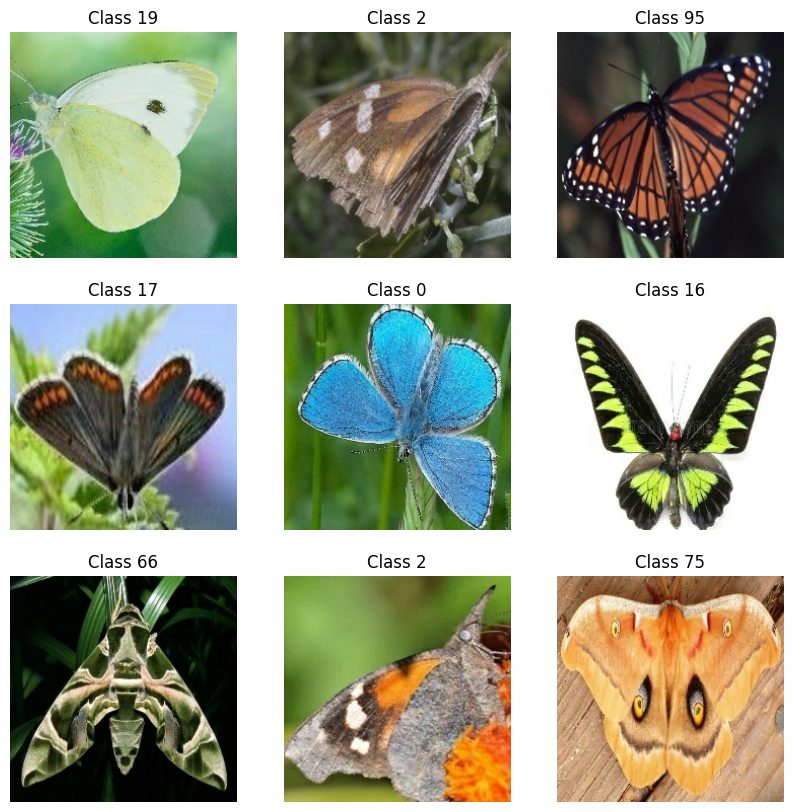

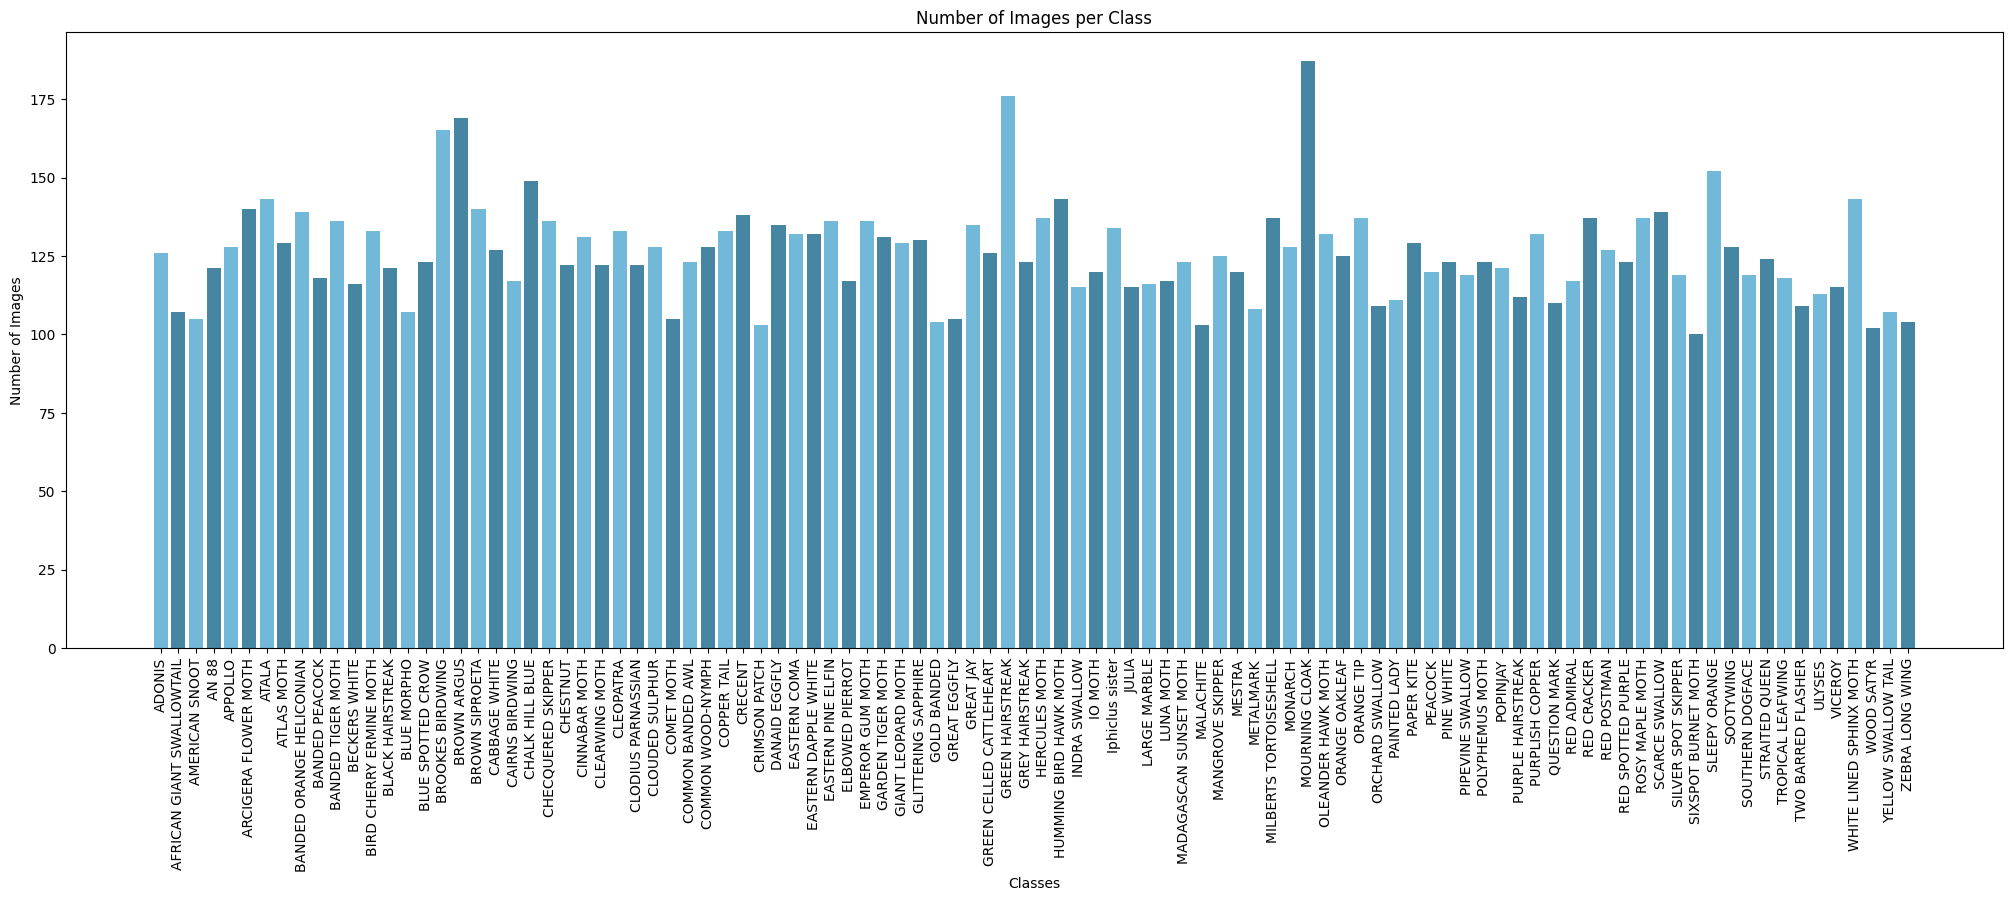

In [4]:
# Data Visualisation
# We will first display some sample images from our dataset
train_iterator = train_data.as_numpy_iterator()
# Create a 3x3 grid to hold our images for compactness
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
images = []
labels = []

# Loop through 9 classes and take an image and class number from the training set
for class_num in range(0, NB_CLASSES, 9):
    batch = train_iterator.next()
    image, label = batch[0][0], batch[1][0]
    class_index = np.argmax(label)
    # Store them in an array so we can later add them to our grid
    images.append(image.astype(np.uint8))
    labels.append(class_index)
    
for i in range(9):
    # Get the row and column position to determine which ax to get
    row_pos = i // 3
    col_pos = i % 3
    ax = axes[row_pos, col_pos]
    # Display the image and class number
    ax.imshow(images[i])
    ax.set_title(f"Class {labels[i]}")
    ax.axis('off')
    
plt.show()

# Get names of all classes from the training directory
class_names = os.listdir(TRAIN_PATH)
class_amounts = []

# Get number of images for each class in the training directory
for name in class_names:
    class_dir = os.path.join(TRAIN_PATH, name)
    class_amounts.append(len(os.listdir(class_dir)))

# Alternate colours
colours = ['#71b8d9', '#4686a3'] * (len(class_names) // 2)

plt.figure(figsize=(25, 8))
plt.bar(class_names, class_amounts, color=colours)
plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

A last preprocessing step we perform is to normalise our data using min-max normalisation.
This is done by making the pixel values range 0 - 1 instead of the typical 0 - 255.

This should help in making the training more 'fair' by making features contribute more equally and avoid certain features contributing too much. Learning from more features should increase the performance of our model.

In [5]:
# Min-max normalisation scales all values to the range 0 - 1
# Division by 255 accomplishes this since the max value for any pixel in any colour channel is 255
train_data = train_data.map(lambda x, y: (x / 255.0, y))
valid_data = valid_data.map(lambda x, y: (x / 255.0, y))
X_test /= 255.0

## The Network Structure and Hyperparameters
We chose to use the AlexNet architecture for our CNN.
The architecture is described by the comments in the code cell below but we'll provide a brief summary:
- Input Size: 227x227x3
- 5 Convolutional layers with varying kernel numbers, kernel sizes and strides, all use the ReLU activation function.
- 3 Max Pooling layers that simplify our inputs while trying to retain the features so that the training process is faster while retaining performance.
- 3 Fully Connected layers with 2 Dropout layers and preceded by a Flatten layer. These layers take extracted features and bring them closer to a format that allows for classification. The dropout tries to lower the chance of overfitting (explained in the code cell).
- An output layer using softmax to determine which label is most likely to be correct.

Other hyperparameters are explained below:
- Batch size is typically 128 for AlexNet
- We settled on 30 epochs to balance training time and model performance. The validation metrics don't improve much beyond 30 epochs, if time wasn't a consideration, 50 epochs could be used but this isn't significantly better from what we can tell.
- Learning rate is 0.001, the default used in the Adam optimiser, higher learning rates tended to provide worse results.

## Loss Function and Optimiser
### Optimiser
We chose an adaptive optimiser instead of a gradient descent optimiser so that the changing learning rate would lead to faster convergence.

Gradient descent optimisers can require a lot of tuning to produce desirable results and even then may not perform as well as adaptive optimisers.

Of the Gradient descent optimisers, Mini Batch Gradient Descent seemed like the best choice for this task as the data we're dealing with is simply too large for Gradient Descent and our dataset is fairly noisy with varying backgrounds so Stochastic Gradient Descent (SGD) may take many iterations before converging. Mini Batch would likely perform better as it cuts down the computation like in SGD but also better accommodates variance in the training data by taking a batch of data, balancing computation and model performance. Despite this, we found adaptive optimisers to be more preferable.

Of the Adaptive optimisers we settled on <b>Adam</b> as it seemed to be the best choice for speed and performance. We looked at AdaGrad, RMS Prop, and Adam. AdaGrad balances the change of parameters and the change of learning rate, but the learning rate tends to become very small, limiting its ability to perform well after some iterations. RMS Prop improves on the learning rate problem in AdaGrad by using an average of squared gradients rather than accumulating the squared gradients. Lastly, Adam updates the mean of the gradient and the rate at which it's changing allowing it to improve effectively and quickly.

Since Adam requires little hyperparameter tuning, tends to run faster than other optimisers, and also tends to have the best performance, we chose it for this task.

### Loss Function
We are using <b>Categorical Cross Entropy</b> (CCE) as our loss function. Since we are using one-hot encoding, CCE seemed appropriate as it would effectively measure the loss as the sum of probabilities assigned to incorrect classes as our actual probabilities will be 0 for every incorrect class and 1 for the correct class. This is a simple yet effective method of guiding our model to assign higher probabilities to the correct class.

If we were to use numerical encoding, then Sparse Categorical Cross Entropy would likely perform approximately as well.

Mean Squared Error, Mean Absolute Error, and Root Mean Squared Error did not seem as appropriate for this classification task as they are better suited for regression tasks. In this case we are focused on assigning the correct class a high probability.  

In [6]:
# Implementation of AlexNet architecture
class AlexNet(Sequential):
    def __init__(self):
        super().__init__()
        self.build_layers()
        # Compiles the model with our chosen optimiser, loss function, and metrics
        self.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    def build_layers(self):
        # The architecture consists of 5 convolutional layers, 3 max pooling layers, 1 flatten layer, 3 fully connected layers (dropout following the first two), and an output layer
        
        # First convolutional layer consists of 96 filters, kernel size of 11x11, and moves in strides of 4
        # This results in an output shape 55x55x96
        self.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation="relu", input_shape=INPUT_SHAPE))
        self.add(layers.BatchNormalization())
        # In max pooling we take the max value of a 3x3 region and move in strides of 2
        # Resultant shape: 27x27x96
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # The resultant shape should be 27x27x256 so we apply even padding
        self.add(layers.Conv2D(256, (5, 5), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        # Resultant shape: 13x13x256
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # Three more convolutional layers, only dimension changing here is z
        self.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        self.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        self.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())

        # Last max pooling layer results in 6x6x256
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # Flatten layer results in 1x1x9216 (6*6*256 = 9216)
        self.add(layers.Flatten())

        # Fully connected layers with dropout to prevent overfitting
        self.add(layers.Dense(4096, activation="relu"))
        # 50% chance for each neuron to be deactivated
        # Reduces overfitting by preventing over reliance on a specific feature and instead learning a more robust set of features
        self.add(layers.Dropout(rate=0.5))
        
        self.add(layers.Dense(4096, activation="relu"))
        self.add(layers.Dropout(rate=0.5))
        
        self.add(layers.Dense(1000, activation="relu"))
        
        # Softmax converts the input into probabilities for each class, emphasising the difference between input values
        self.add(layers.Dense(NB_CLASSES, activation="softmax"))

model = AlexNet()
model.summary()

C:\Users\bayan\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "alex_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │       100,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,483,948 (238.36 MB)

 Trainable params: 62,481,196 (238.35 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [7]:
# Training our model

training_start_time = time.time()
# Training
model_history = model.fit(train_data, epochs=EPOCHS, validation_data=valid_data, verbose=VERBOSE)
training_end_time = time.time()
total_training_time = training_end_time - training_start_time

# Displaying the total training time in minutes and seconds
print(f"Total training time: {total_training_time/60:.0f}m{total_training_time%60:.0f}s")

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.0301 - loss: 8.0776 - precision: 0.0246 - recall: 0.0019 - val_accuracy: 0.0200 - val_loss: 4.9798 - val_precision: 0.0625 - val_recall: 0.0100
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.0930 - loss: 3.8330 - precision: 0.2881 - recall: 0.0077 - val_accuracy: 0.0620 - val_loss: 4.1566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.1707 - loss: 3.2976 - precision: 0.4553 - recall: 0.0360 - val_accuracy: 0.1860 - val_loss: 3.3275 - val_precision: 0.5238 - val_recall: 0.0220
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2629 - loss: 2.8400 - precision: 0.5486 - recall: 0.0941 - val_accuracy: 0.2720 - val_loss: 2.7408 - val_precision: 0.5566 - val_recall: 0.1180
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3415 - loss: 2.4562 - precision: 0.6323 - recall: 0.1722 - val_accuracy: 0.3940 - val_loss:

In [8]:
    # Obtaining metrics and calculating performance of our model to be used in visualising and evaluating results later

# Obtaining metrics from training
training_accuracy = model_history.history["accuracy"]
training_precision = model_history.history["precision"]
training_recall = model_history.history["recall"]
training_loss = model_history.history["loss"]

# Obtaining metrics from validation
validation_accuracy = model_history.history["val_accuracy"]
validation_precision = model_history.history["val_precision"]
validation_recall = model_history.history["val_recall"]
validation_loss = model_history.history["val_loss"]

# Evaluating model against test data
model_results = model.evaluate(X_test, y_test, verbose=VERBOSE)

# Getting predicted results
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8243 - loss: 0.8453 - precision: 0.8726 - recall: 0.7915
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


## Cross Fold Validation
Cross Fold validation was done separately so that we could try both using the validation dataset provided and by using the training dataset for validation to see if there was any noticeable difference in the results.

We are using the same model, optimiser, loss function, hyperparameters, so that the results we get from cross fold validation can be compared with the results from the other approach.

We chose to split the dataset into 3 equal-sized parts, 2 of which are being used for training and the other for validation. This also differs from the previous model we trained in that there is less training data and significantly more validation data.

The process by which we did this is explained in the comments in the below code cell. The results are also provided in the output of the code cell. We average the results of the three models to gauge if combining these three models would yield better results than the single model approach.

In [9]:
# Training models with Cross Fold Validation

# Splits is the number of folds
splits = 3
# Total number of elements in the training data
dataset_size = len(list(train_data))
# The number of elements in each fold
fold_size = dataset_size // splits
# The results of each fold will be stored in this array
models_results = []

# For each fold we will split the training data into 3 parts, 2 for training and 1 for validation and repeat for each possible permutation
for fold in range(splits):
    # We clear session so trained models don't interfere with each other
    backend.clear_session()
    # Create a new model
    model = AlexNet()
    # Train the model with the specific training sets and validation set
    # Get the 'fold'th' third of the training data for validation (either the 1st, 2nd, or 3rd third)
    valid_fold = train_data.skip(fold * fold_size).take(fold_size)
    # Get the remaining training data for training (gets the data after the validation split and concatenates the data before the validation split)
    train_fold = train_data.skip((fold+1) * fold_size).concatenate(train_data.take(fold * fold_size))
    
    model.fit(train_fold, epochs=EPOCHS, validation_data=valid_fold, verbose=VERBOSE)
    # Evaluate the model and store the results
    models_results.append(model.evaluate(X_test, y_test))


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.0238 - loss: 10.1312 - precision: 0.0119 - recall: 0.0017 - val_accuracy: 0.0135 - val_loss: 5.8881 - val_precision: 0.0349 - val_recall: 0.0014
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0636 - loss: 4.1808 - precision: 0.3192 - recall: 0.0049 - val_accuracy: 0.0417 - val_loss: 4.2811 - val_precision: 1.0000 - val_recall: 2.3674e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0825 - loss: 3.8314 - precision: 0.2903 - recall: 0.0064 - val_accuracy: 0.0862 - val_loss: 3.9919 - val_precision: 0.2500 - val_recall: 0.0014
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1291 - loss: 3.5419 - precision: 0.3902 - recall: 0.0202 - val_accuracy: 0.0679 - val_loss: 4.5506 - val_precision: 0.1235 - val_recall: 0.0024
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1753 - loss: 3.2807 - precision: 0.4925 - recall: 0.0421 - val_accuracy: 0.0694 - val_loss: 4.2867

## Results
### Single Model Results

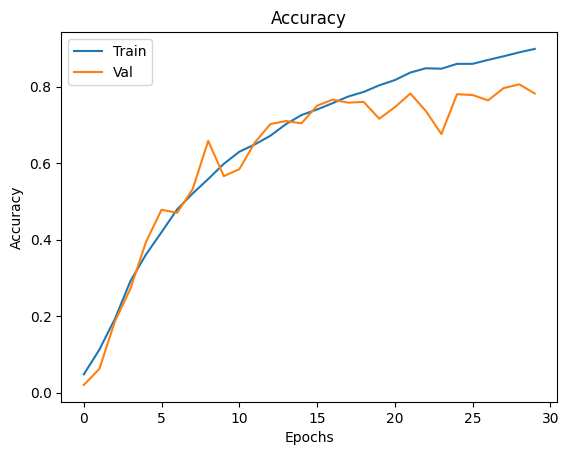

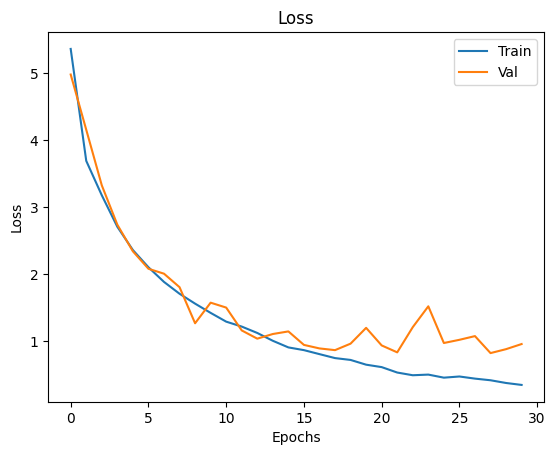

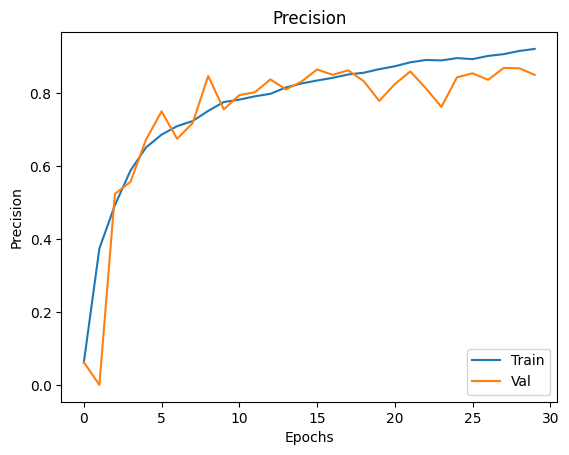

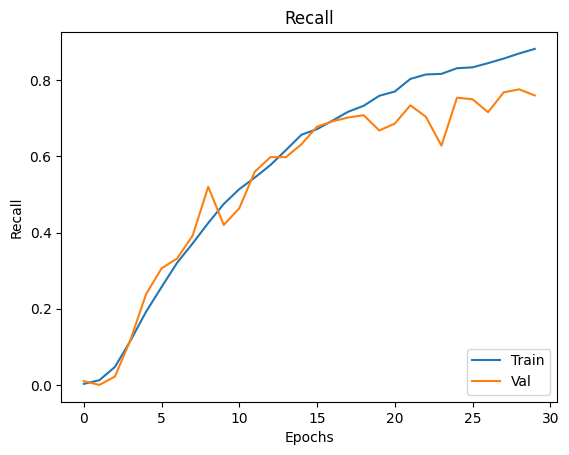

In [10]:
# Single model results
# Visualising training results over time

# Plotting model accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Plotting model loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

# Plotting model precision
plt.plot(training_precision)
plt.plot(validation_precision)
plt.title("Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Plotting model recall
plt.plot(training_recall)
plt.plot(validation_recall)
plt.title("Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

Test loss:  0.7867
Test accuracy:  82.8 %
Test Precision:  87.0 %
Test Recall:  80.0 %


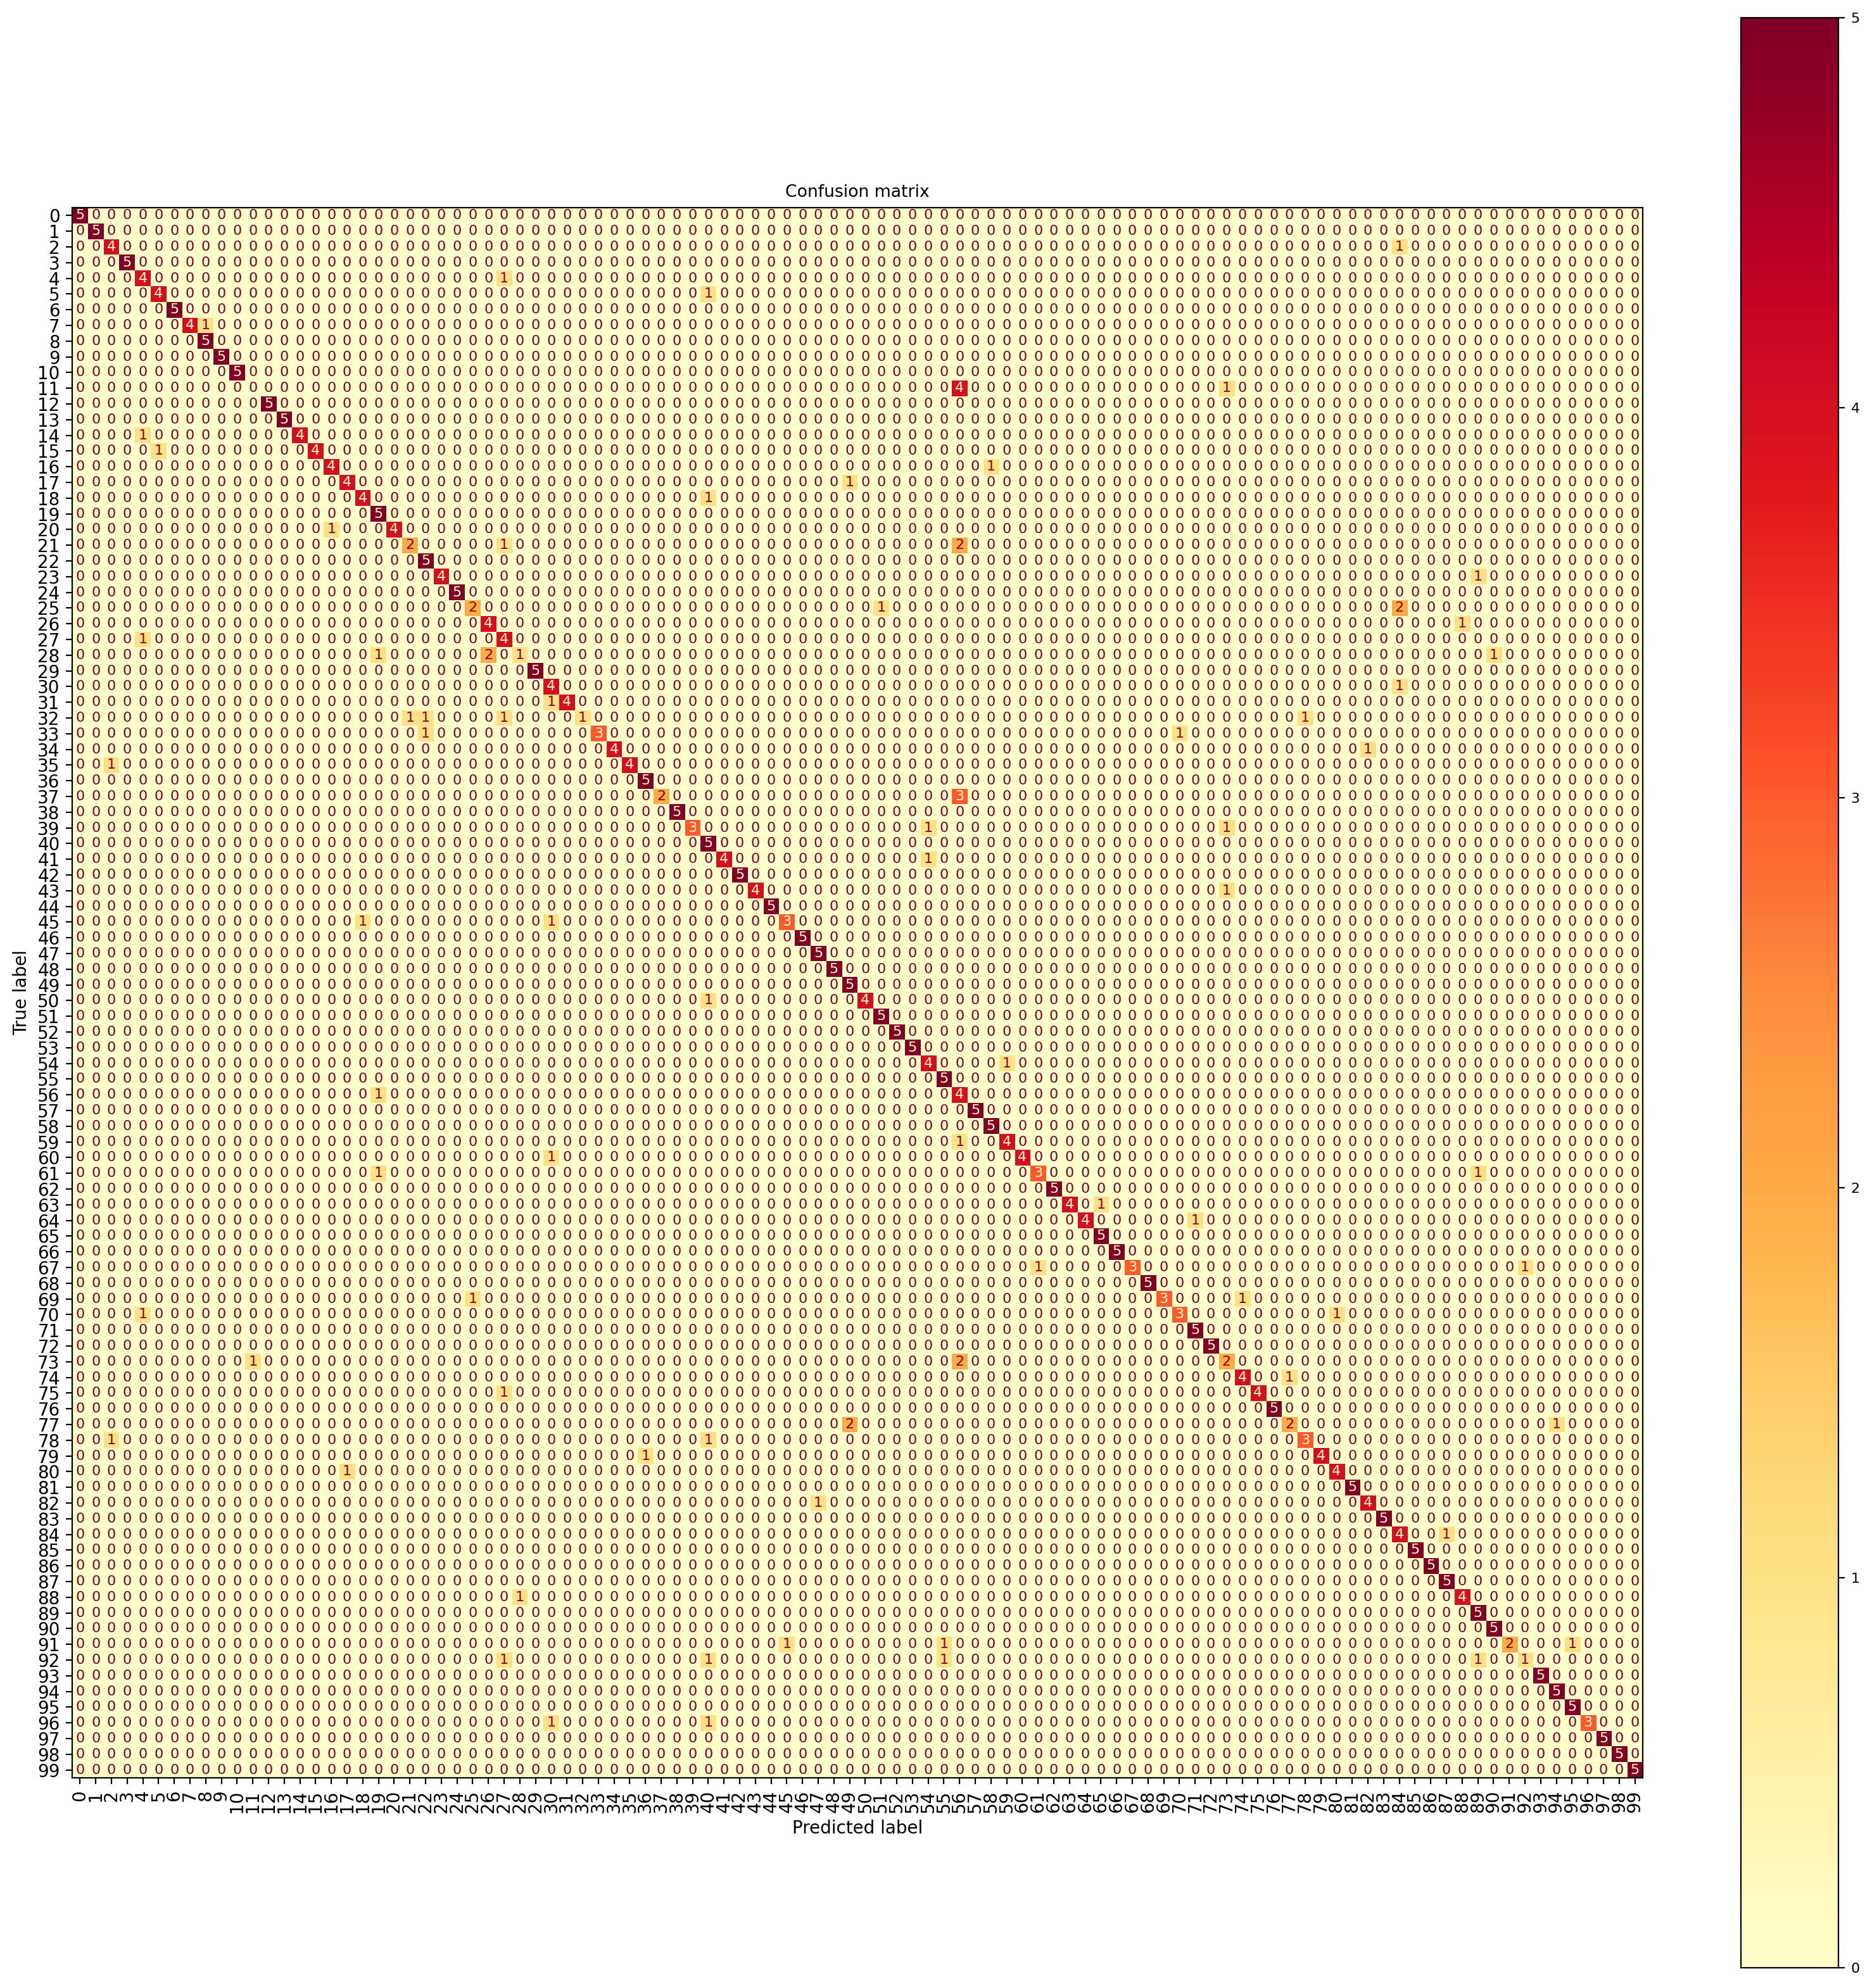

In [11]:
# Printing test results
print("Test loss: ", round(model_results[0], 4))
print("Test accuracy: ", round(model_results[1]*100, 1), "%")
print("Test Precision: ", round(model_results[2]*100, 1), "%")
print("Test Recall: ", round(model_results[3]*100, 1), "%")

# Visualising test results
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Computing confusion matrix
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
classes = [str(i) for i in range(NB_CLASSES)]
cm_display = metrics.ConfusionMatrixDisplay(cm)

# The matrix is 100x100 so the following lines make it a bit more visually accessible
fig, ax = plt.subplots(figsize=(20, 20), dpi=200)
plt.rcParams.update({"font.size": 8})

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd", xticks_rotation="vertical")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### Cross Fold Validation Results

In [12]:
# Cross fold validation results

# Print the loss, accuracy, precision, and recall for each model
for index, results in enumerate(models_results):
    print("\nModel", index, "loss:", round(models_results[index][0], 4))
    print("Model", index, "accuracy:", round(models_results[index][1]*100, 1), "%")
    print("Model", index, "precision:", round(models_results[index][2]*100, 1), "%")
    print("Model", index, "recall:", round(models_results[index][3]*100, 1), "%")

# Calculate the averages of each metric
models_results = np.sum(models_results, axis=0)
avg_loss = round((models_results[0] / 3), 4)
avg_accuracy = round((models_results[1] / 3), 4)
avg_precision = round((models_results[2] / 3), 4)
avg_recall = round((models_results[3] / 3), 4)

# Print the average metrics
print("\nAverage loss:", avg_loss)
print("Average accuracy:", avg_accuracy*100, "%")
print("Average Precision:", avg_precision*100, "%")
print("Average Recall:", avg_recall*100, "%")


Model 0 loss: 0.8052
Model 0 accuracy: 76.4 %
Model 0 precision: 85.7 %
Model 0 recall: 71.8 %

Model 1 loss: 0.99
Model 1 accuracy: 73.4 %
Model 1 precision: 81.9 %
Model 1 recall: 68.8 %

Model 2 loss: 1.0569
Model 2 accuracy: 73.8 %
Model 2 precision: 81.0 %
Model 2 recall: 69.2 %

Average loss: 0.9507
Average accuracy: 74.53 %
Average Precision: 82.87 %
Average Recall: 69.93 %


## Evaluation of the Results

<b>Refs:</b>

AlexNet Architecture:

https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide

https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5

Keras docs:

https://keras.io/api

Matplotlib docs:

https://matplotlib.org/stable/index.html

Scikit-learn docs:

https://scikit-learn.org/stable/api/index.html